# Bayesian inference

## [Scientific Computing with Python](http://scicompy.yoavram.com)
## Yoav Ram

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
sns.set_context('talk')

red, blue, green = sns.color_palette('Set1', 3)

# Bayesian inference

Bayesian inference is a method of statistical inference in which Bayes' theorem is used to update the probability for a hypothesis as more evidence or information becomes available. 

**Bayes' theorem**.
Consider the events $A$ and $B$, then Bayes' theorem states that

$$
P(A \mid B) = \frac{P(B \mid A) P(A)}{P(B)}
$$

Applied to model-based inference, we define:
- $\theta$ are the model parameters
- $X$ are the data
and we have
$$
P(\theta \mid X) = \frac{P(X \mid \theta) P(\theta)}{P(X)}
$$
where
- $P(\theta)$ is called the *prior probability* that formulates our beliefs about the model before seeing any data
- $P(X \mid \theta)$ is the probability of observing $X$ given $\theta$, what we called the *likelihood of $\theta$*
- $P(\theta \mid X)$ is called the *posterior probability*, that is, how our beliefs about the model changed due to observing the data
- $P(X)$ is the probability of observing the data unconditioned on the model; we usually ignore it as it does not depend on the model

In Bayesian inference we attempt to estimate the posterior distribution over the model parameters; this constrast with classical/frequentist approaches like *maximum likelihood* in which we attempt to estimate a point estimate of the parameters - a single parameter value.

# Bayesian vs. frequentist approach: counting photons

This example follows a [blog post by Jake VanDerPlas](http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/).

Imagine that we point our telescope to the sky, and observe the light coming from a single star. For the time being, we'll assume that the star's true flux is constant with time, i.e. that is it has a fixed value $F_{\rm true}$ (we'll also ignore effects like sky noise and other sources of systematic error). We'll assume that we perform a series of $N$ measurements with our telescope, where the $i^{\rm th}$ measurement reports the observed photon flux $F_i$ and error $e_i$.

The question is, given this set of measurements $D = \{F_i,e_i\}$, what is our best estimate of the true flux $F_{\rm true}$?

We start by generating some data.

In [64]:
np.random.seed(1)

# true flux: number of photons measured in 1 second
F_true = 1000  
# number of measurements
N = 50 
# N measurements of the flux
F = scipy.stats.poisson(F_true).rvs(N)  
# errors estimated via square root: expectation=variance in Poisson
e = np.sqrt(F)  

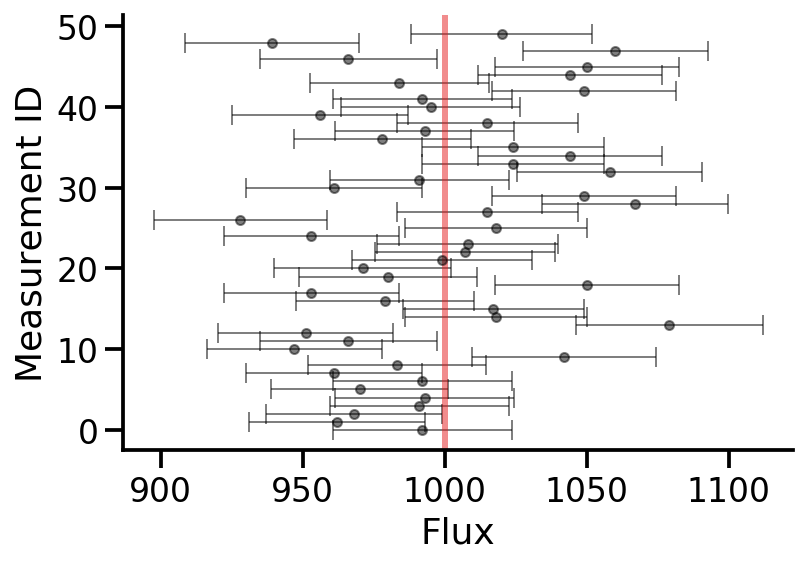

In [67]:
plt.errorbar(F, np.arange(N), xerr=e, fmt='.k',capsize=5, ecolor='k', linewidth=1, alpha=0.5)
plt.axvline(F_true, linewidth=3, alpha=0.5, color=red)
plt.xlabel("Flux")
plt.ylabel("Measurement ID")
sns.despine()

In this toy example we already know the
true flux $F_{\rm true}$, but the question is this: **given our measurements and errors, what is our best estimate of the true flux?**

### Frequentist Approach

We'll make the reasonable assumption that measurement errors are Gaussian.

Given a single observation $D_i = (F_i, e_i)$, we can compute the probability distribution of the measurement given the true flux $F_{\rm true}$ given our assumption of Gaussian errors:

$$
P(D_i~|~F_{\rm true}) = 
\frac{1}{\sqrt{2\pi e_i^2}} \exp{\left[\frac{-(F_i - F_{\rm true})^2}{2 e_i^2}\right]}
$$

We construct the **likelihood function** by computing the product of the probabilities for each data point:

$$
\mathcal{L}(D~|~F_{\rm true}) = 
\prod_{i=1}^N P(D_i~|~F_{\rm true})
$$
where $D = \{D_i\}$.

The likelihood is a product of exponents, so we take the log-likelihood:

$$
\log\mathcal{L} = 
-\frac{1}{2} \sum_{i=1}^N \left[ \log(2\pi  e_i^2) + \frac{(F_i - F_{\rm true})^2}{e_i^2} \right]
$$

In [94]:
def logL(F, F_true):
    e = np.sqrt(F)
    return -0.5 * (np.log(2 * np.pi*  e**2) + (F - F_true)**2 / (e**2)).sum()

Here's a plot of the log-likelihood function, with the true value in red circle and the measured values in black dots.

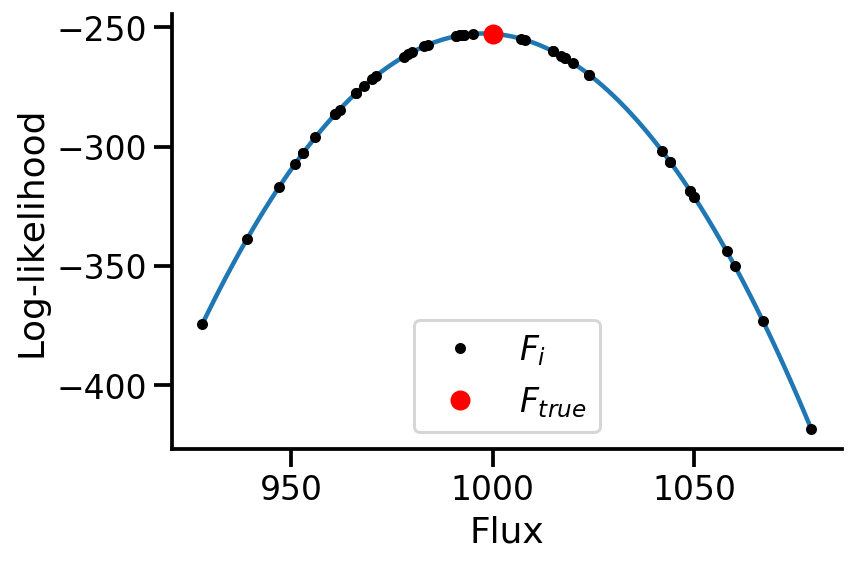

In [114]:
F_range = np.linspace(F.min(), F.max(),100)
plt.plot(F_range, [logL(F, F_) for F_ in F_range])
plt.plot(F, [logL(F, F_) for F_ in F], '.k', label='$F_i$')
plt.plot(F_true, logL(F, F_true), 'or', label='$F_{true}$')
plt.xlabel("Flux")
plt.ylabel("Log-likelihood")
plt.legend()
sns.despine()

We now use *maximum likelihood* and estimate the flux value $F_{\rm est}$ that maximizes the log-likelihood $\log\mathcal{L}$. 

We can find this analytically by solving for the root of the derivative, 

$$
\frac{d\log\mathcal{L}}{dF_{\rm true}} (F_{\rm est}) = 0
\\ \Rightarrow 
-\frac{1}{2} \sum_{i=1}^N -2\frac{F_i - F_{\rm true}}{e_i^2} = 0 
\\ \Rightarrow 
\sum_{i=1}^N \frac{F_i - F_{\rm true}}{e_i^2} = 0 
$$

Remember that $e_i = \sqrt{F_i}$, so

$$
\Rightarrow 
\sum_{i=1}^N \frac{F_i }{F_i} - \sum_{i=1}^N \frac{F_{\rm true}}{F_i}  = 0
\\ \Rightarrow 
N - F_{\rm true} \sum_{i=1}^N \frac{1}{F_i} = 0
\\ \Rightarrow 
F_{\rm true}  = \frac{N}{\sum_{i=1}^N \frac{1}{F_i}}
$$


In [106]:
F_est = N / (1/F).sum()

print("F_true = {}, F_est = {}".format(F_true, F_est))

Here's a plot of the log-likelihood function in the vicinity of the maximum likelihood estmation (MLE).

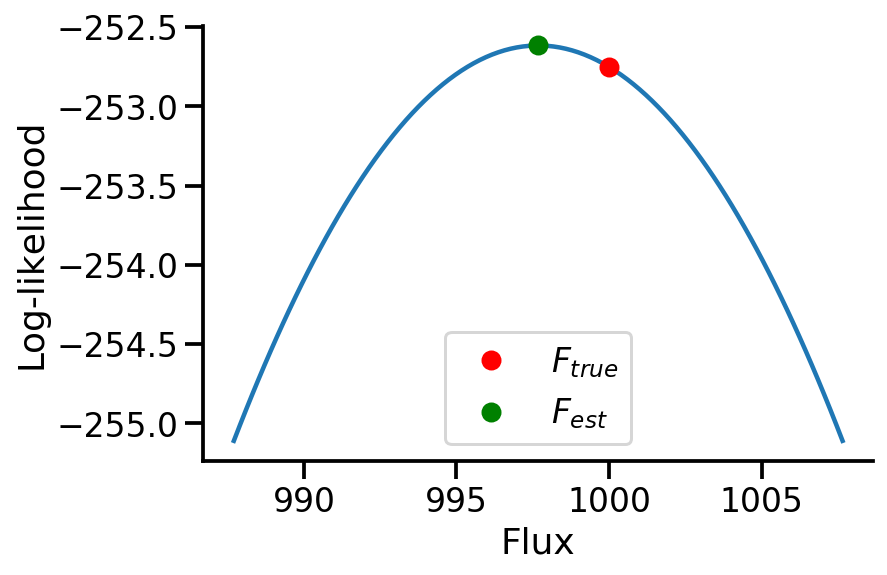

In [115]:
F_range = np.linspace(F_est*0.99, F_est*1.01, 100)
plt.plot(F_range, [logL(F, F_) for F_ in F_range])
plt.plot(F_true, logL(F, F_true), 'or', label='$F_{true}$')
plt.plot(F_est, logL(F, F_est), 'og', label='$F_{est}$')
plt.xlabel("Flux")
plt.ylabel("Log-likelihood")
plt.legend()
sns.despine()

# References

- Jake VanDerPlas's series of [blog posts on Beysian inference](http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/)

# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com) and is part of the [_Scientific Computing with Python_](https://scicompy.yoavram.com/) course at IDC Herzliya.

The notebook was written using [Python](http://python.org/) 3.6.5.
Dependencies listed in [environment.yml](../environment.yml).

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)